**Objectif de ce notebook**<br>
Améliorer la qualité des données afin de les préparer pour le Machine Learning. Ceci permettra d’accroître l’exactitude du modèle de prédiction.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno

In [2]:
data = pd.read_csv("building_data_cleaned.csv")
data.sample(5)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,Neighborhood,NumberofBuildings,NumberofFloors,...,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,harvesine_distance
1455,40008,2016,NonResidential,Mixed Use Property,(ID#40008) KC Metro Transit Power Distribution,2255 4TH AVE S,98134.0,GREATER DUWAMISH,1.0,3,...,57.799999,136.000000,1.554599e+06,0.0,969591.0,585008.0,37.83,1.72,12,2.666318
383,597,2016,NonResidential,Large Office,635 Elliott - South Bldg.,635 Elliott Avenue West,98119.0,MAGNOLIA / QUEEN ANNE,1.0,4,...,34.200001,106.599998,6.657348e+06,0.0,6585119.0,72228.0,49.74,0.17,7,3.385242
1018,23672,2016,NonResidential,Small- and Mid-Sized Office,2324 Eastlake,2324 Eastlake Ave E,98102.0,LAKE UNION,1.0,4,...,73.800003,231.699997,2.520483e+06,0.0,2520483.0,0.0,17.57,0.31,30,3.833283
1429,28053,2016,NonResidential,Worship Facility,(ID28053)CONGREGATION BETH SHALOM,6800 35TH AVE NE,98115.0,NORTHEAST,1.0,1,...,29.600000,67.800003,8.616437e+05,0.0,511118.0,350526.0,22.18,0.76,61,8.599552
1485,49783,2016,NonResidential,Laboratory,UW Medicine Phase 3.1,750 Republican Street,98109.0,LAKE UNION,1.0,8,...,240.899994,547.700012,4.169646e+07,0.0,24410204.0,17286256.0,1088.25,3.20,3,2.045609


In [3]:
data.shape

(1544, 31)

**Les variables ayant une forte corrélation entre elles peuvent influencer la qualité du model de prédiction. On se donc de rechercher la présence des variables corrélées et de les transformer pour réduire leur impact sur la prédiction.**

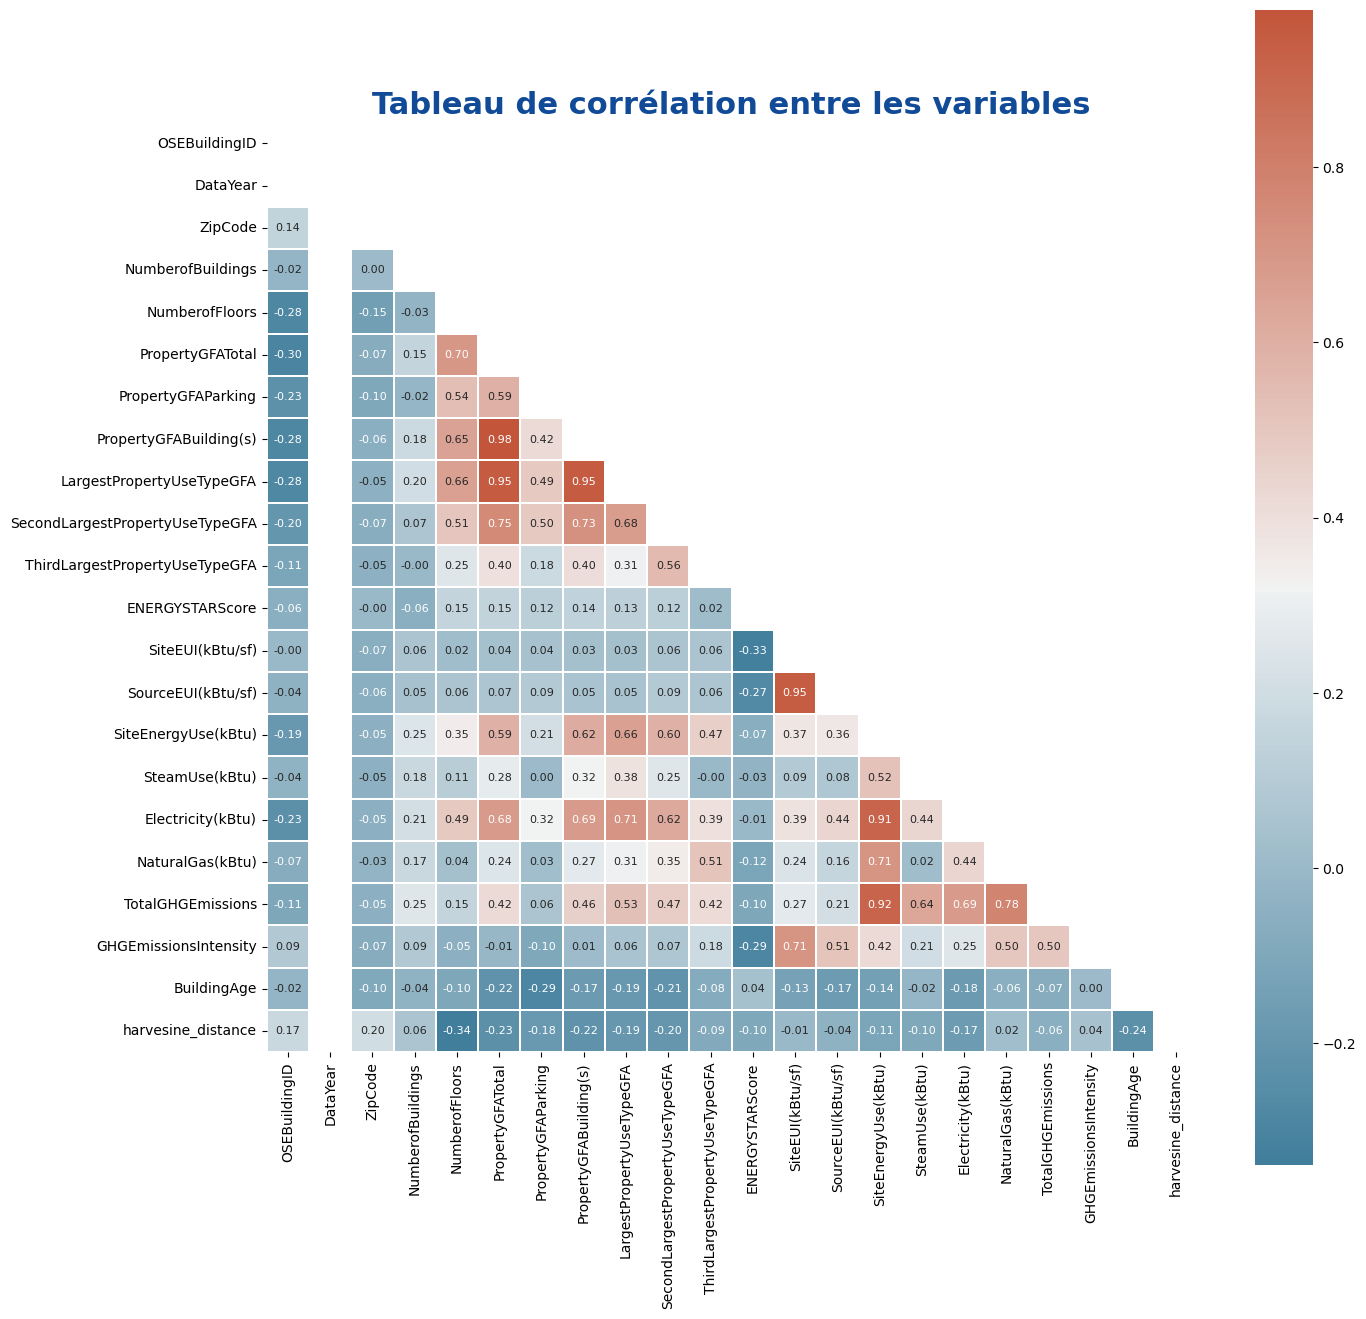

In [4]:
# Réalisation du test de corrélation de Pearson et affichage des résultats dans un heatmap

police_titre = {'family': 'sans serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 22,
             }

#Matrice des corrélations
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

#heatmap
fig = plt.figure(figsize=(15,15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, square=True, linewidths=0.01, mask = mask, annot=True, cmap=cmap, fmt='.2f', annot_kws={'size':8})
plt.title("Tableau de corrélation entre les variables", fontdict=police_titre)
plt.show()

Plusieurs variables présentent des fortes corrélations positives entre elles. Affichons les variables fortement correlées (corrélation de Pearson > 0,69) sous sous forme de tableau

In [5]:
threshold = 0.69 # Définition du seuil

corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
26,PropertyGFABuilding(s),PropertyGFATotal,0.979658
24,LargestPropertyUseTypeGFA,PropertyGFATotal,0.951869
22,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,0.950167
20,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),0.946487
18,SiteEnergyUse(kBtu),TotalGHGEmissions,0.916392
16,SiteEnergyUse(kBtu),Electricity(kBtu),0.914477
14,TotalGHGEmissions,NaturalGas(kBtu),0.778918
12,PropertyGFATotal,SecondLargestPropertyUseTypeGFA,0.753533
10,SecondLargestPropertyUseTypeGFA,PropertyGFABuilding(s),0.726252
8,SiteEUI(kBtu/sf),GHGEmissionsIntensity,0.712939


Les variables avec les affixes GFA sont fortement corrélées avec les autres variables. Pour réduire ces corrélations, je vais procéder à la création de nouvelles variables pour substituer les variables fortement corrélées, sans altérer la qualité des données.

Les variables aux affixes GFA (gross floor area) renseignent sur la surface réservée à un usage. On peut donc rammener ces variables à la totalité des utilisations du bâtiment. Pour cela il faudrait encoder la variable "ListOfAllPropertyUseTypes". Vérifions que l'encodage soit possible : 

In [6]:
# Combien de types d'usage sont représentés dans le jeu de données ?

def split_words(data, column = None):
    """Recherche et sépare les mots dans une variable"""
    list_words = set()
    for word in data[column].str.split(','):
        if isinstance(word, float):
            continue
        list_words = set().union(word, list_words)
    return list(list_words)

In [7]:
list_use_type = split_words(data, 'ListOfAllPropertyUseTypes')
print("Nombre de type d'usages dans le jeu de données : ", len(list_use_type))

Nombre de type d'usages dans le jeu de données :  115


Réaliser un encodage sur 115 éléments ne serait pas judicieux. Dans ce contexte, on peut créer une variable donnant le nombre d'usage des bâtiments. 

In [8]:
data.shape

(1544, 31)

In [9]:
# Création de la nouvelle variable
data["TotalUseTypeNumber"] = [str(word).count(",") + 1 for word in data["ListOfAllPropertyUseTypes"].str.split(",")]

In [10]:
# Suppression de la variable ListOfAllPropertyUseTypes sans utilité désormais
data.drop("ListOfAllPropertyUseTypes", axis = 1, inplace = True)

In [11]:
data.shape

(1544, 31)

Affichons le dataframe avec uniquement les typed d'usage et leur réprésentation

In [12]:
def recherche_composante(data, suffixe = None):
    composante = []
    for col in data.columns:
        if suffixe in col:
            composante.append(col)
    return composante
variable_gfa = recherche_composante(data, suffixe="GFA")
data[['TotalUseTypeNumber'] + variable_gfa].sample(10)

,TotalUseTypeNumber,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
913,1,29214,0,29214,29214.0,0.0,0.0
777,1,27838,0,27838,27838.0,0.0,0.0
697,1,25480,0,25480,25480.0,0.0,0.0
949,3,29258,0,29258,31991.0,2648.0,0.0
426,1,76624,0,76624,76624.0,0.0,0.0
657,1,22860,0,22860,22860.0,0.0,0.0
1157,1,43615,0,43615,43615.0,0.0,0.0
1093,2,21755,0,21755,17650.0,2400.0,0.0
128,5,419848,335109,84739,335109.0,65000.0,13567.0
894,1,26930,6350,20580,26930.0,0.0,0.0


Nous avons deux types de superficie représenté dans le jeu de données : "PropertyGFAParking" et "PropertyGFABuilding(s)". Nous pouvons alors convertir les différentes surfaces (Buildings et Parking) en pourcentage de la surface totale.

In [13]:
# Calcul des ratios
#On calcule les ratios
data['GFABuildingRate'] = (round((data['PropertyGFABuilding(s)'].fillna(0)
                                  /data['PropertyGFATotal'].fillna(0)),2))
data['GFAParkingRate'] = (round((data['PropertyGFAParking'].fillna(0)
                                 /data['PropertyGFATotal'].fillna(0)),2))

In [14]:
# Suppression des variables désormais sans utilités
data.drop(columns = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
           'SecondLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA',
           'ThirdLargestPropertyUseType', 'PropertyGFAParking',
           'PropertyGFABuilding(s)'], inplace=True)

In [15]:
data.shape

(1544, 26)

Avant de poursuivre, observons l'impact de ces transformation sur la corrélation entre les variables

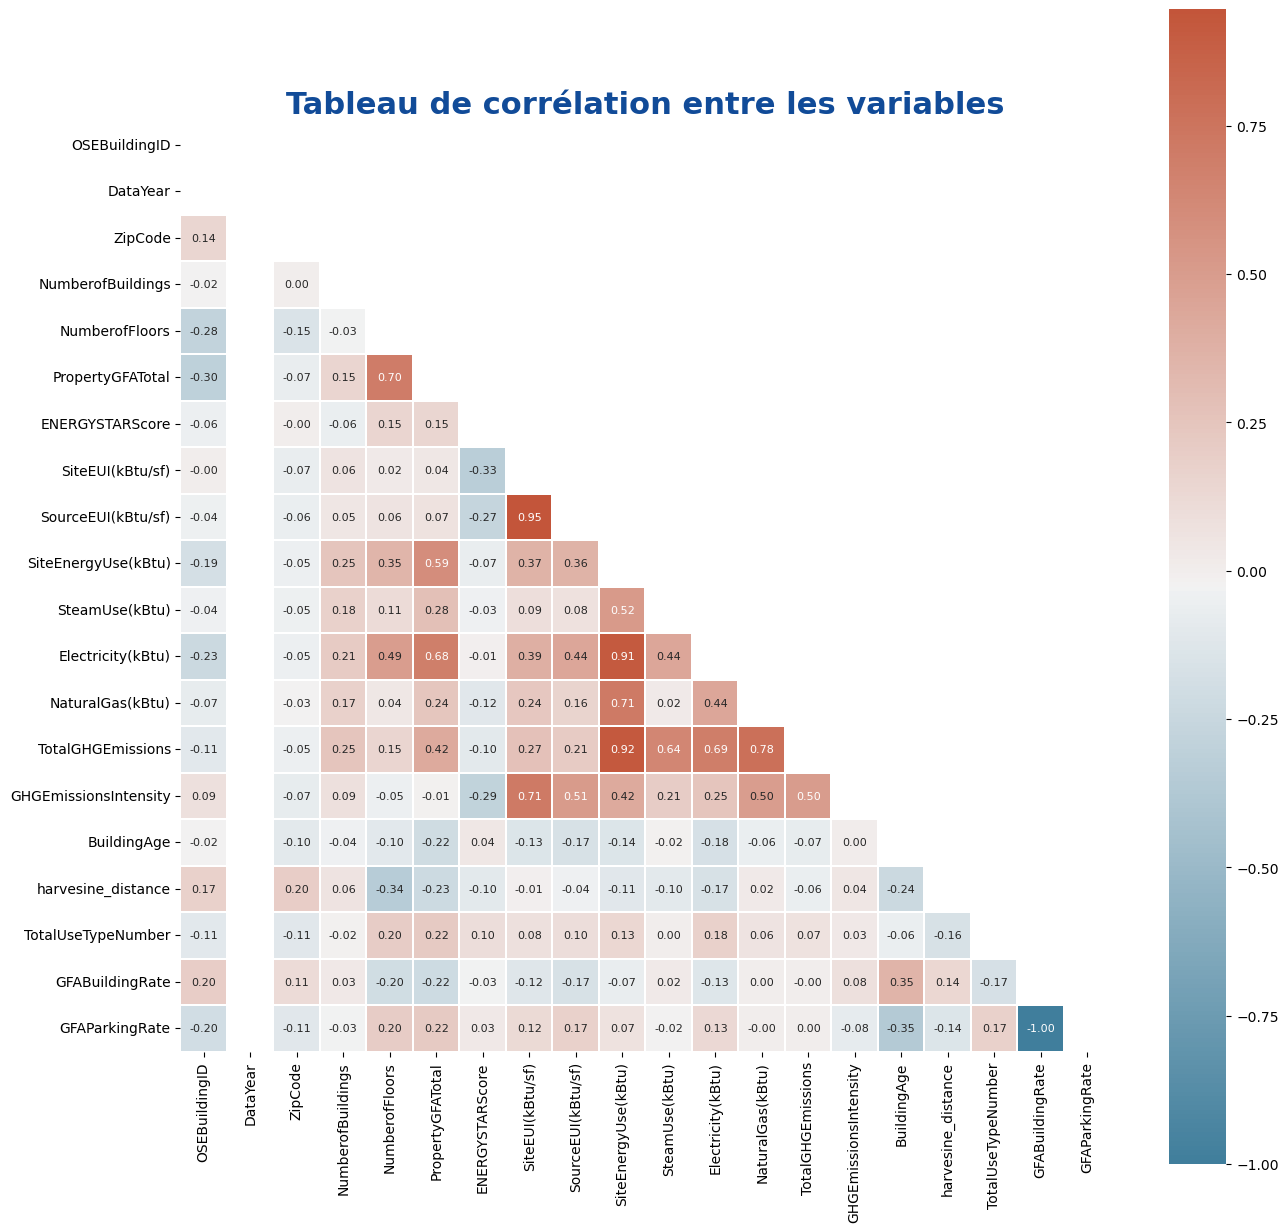

In [16]:
#Matrice des corrélations
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

#heatmap
fig = plt.figure(figsize=(15,15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, square=True, linewidths=0.01, mask = mask, annot=True, cmap=cmap, fmt='.2f', annot_kws={'size':8})
plt.title("Tableau de corrélation entre les variables", fontdict=police_titre)
plt.show()

In [17]:
threshold = 0.69 # Définition du seuil

corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
16,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),0.946487
14,SiteEnergyUse(kBtu),TotalGHGEmissions,0.916392
12,SiteEnergyUse(kBtu),Electricity(kBtu),0.914477
10,NaturalGas(kBtu),TotalGHGEmissions,0.778918
8,GHGEmissionsIntensity,SiteEUI(kBtu/sf),0.712939
6,SiteEnergyUse(kBtu),NaturalGas(kBtu),0.712504
4,PropertyGFATotal,NumberofFloors,0.698118
2,Electricity(kBtu),TotalGHGEmissions,0.690038
0,GFAParkingRate,GFABuildingRate,-1.000000


Les transformations ont permis de réduire quelques corrélations entre variables. Néamoins, il existe encore des fortes corrélations notamment avec les variables  aux suffixes EUI(kBtu/sf). Ces dernières ramènenent l'utilisation de l'énergie à la surface par étage. <br> Nous pouvons les supprimer, car nous avons les utilisations totales par bâtiment.

In [18]:
# Recherche des variables aux suffixes "EUI(kBtu/sf"
Variable_EUI = recherche_composante(data, suffixe='EUI(kBtu/sf)')

In [19]:
# Suppression des variables aux suffixes EUI(kBtu/sf)
data.drop(Variable_EUI, axis = 1, inplace= True)

La variable "GHGEmissionsIntensity" renseigne sur l'émissions totales de gaz à effet de serre divisées par la surface de la propriété. Hors, On retrouve aussi cette information dans la variable "TotalGHGEmissions". On peut donc supprimer la variable "GHGEmissionsIntensity". <br> La variable cible pour les émissions de gaz à effet de serre sera alors "TotalGHGEmissions"

In [20]:
# Suppression de la variable "GHGEmissionsIntensity"
data.drop("GHGEmissionsIntensity", axis = 1, inplace = True)

In [21]:
data.shape

(1544, 23)

Observons à nouveau l'impact de ces transformations sur la corrélation entre les variables.

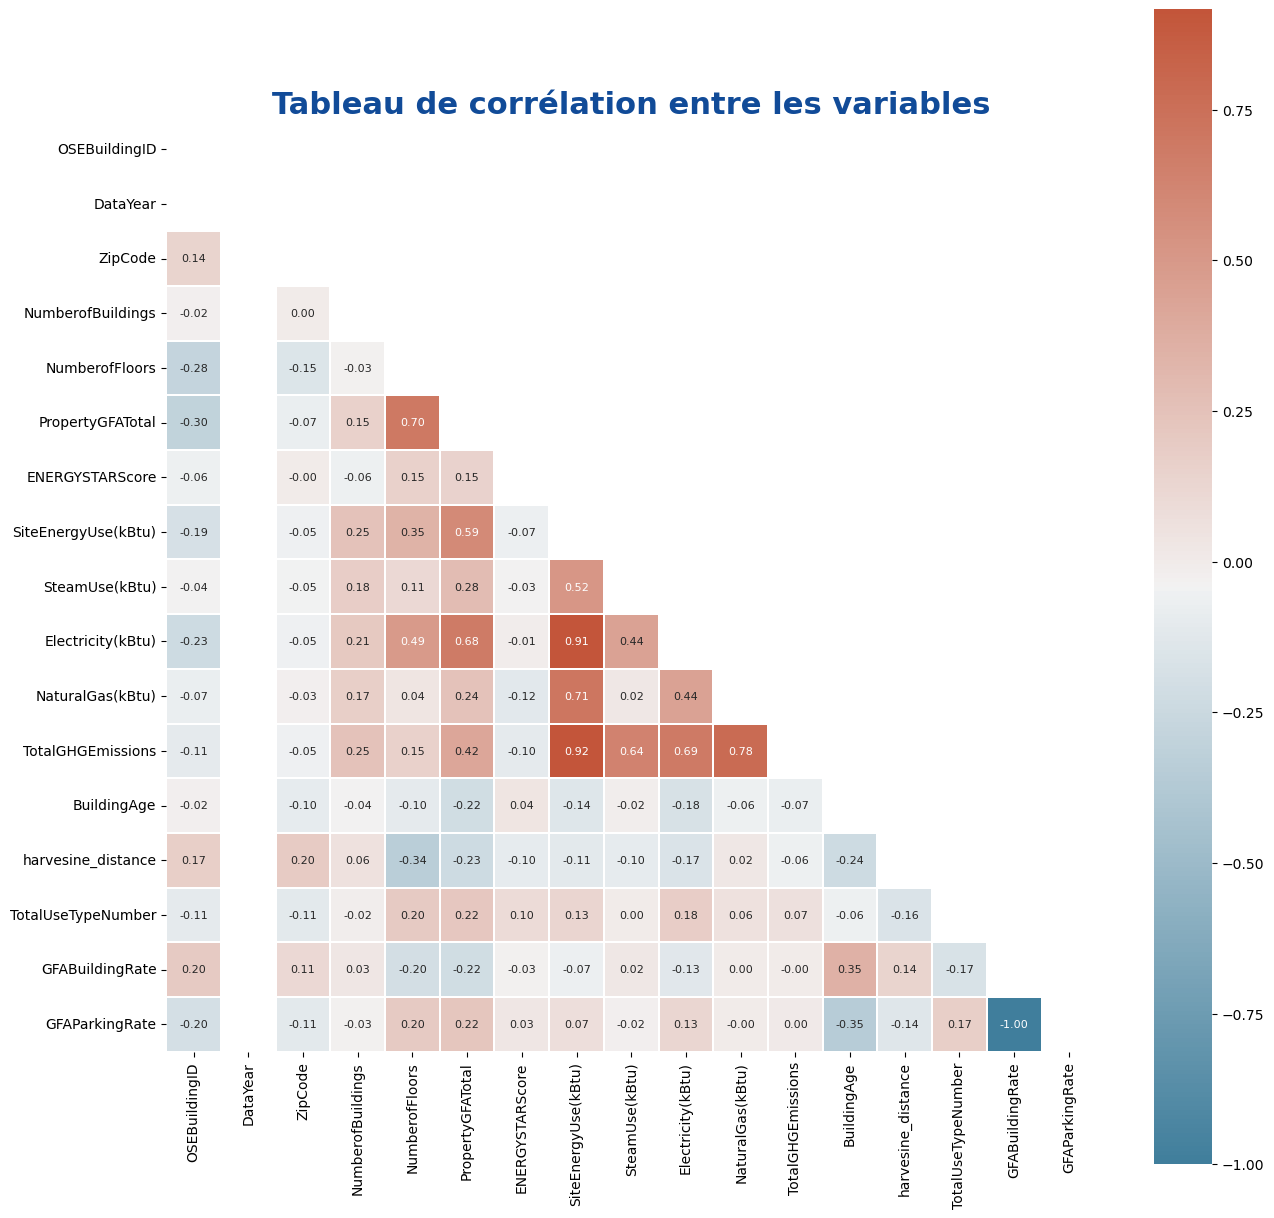

In [22]:
# Matrice des corrélations
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

#heatmap
fig = plt.figure(figsize=(15,15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, square=True, linewidths=0.01, mask = mask, annot=True, cmap=cmap, fmt='.2f', annot_kws={'size':8})
plt.title("Tableau de corrélation entre les variables", fontdict=police_titre)
plt.show()

In [23]:
threshold = 0.69 # Définition du seuil

corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
12,SiteEnergyUse(kBtu),TotalGHGEmissions,0.916392
10,Electricity(kBtu),SiteEnergyUse(kBtu),0.914477
8,TotalGHGEmissions,NaturalGas(kBtu),0.778918
6,NaturalGas(kBtu),SiteEnergyUse(kBtu),0.712504
4,NumberofFloors,PropertyGFATotal,0.698118
2,TotalGHGEmissions,Electricity(kBtu),0.690038
0,GFABuildingRate,GFAParkingRate,-1.000000


In [24]:
data.shape

(1544, 23)

**_NB :_** _La consigne est de créer un modèle de prédiction qui se base sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...). Les variables relatives aux données rélevées peuvent donc être exclure._

In [25]:
# Suppression des variables de relevées
data.drop(["Electricity(kBtu)", "NaturalGas(kBtu)", "SteamUse(kBtu)"], axis = 1, inplace = True)

_Observons à nouveau l'impact de ces transformations sur la corrélation entre les variables._

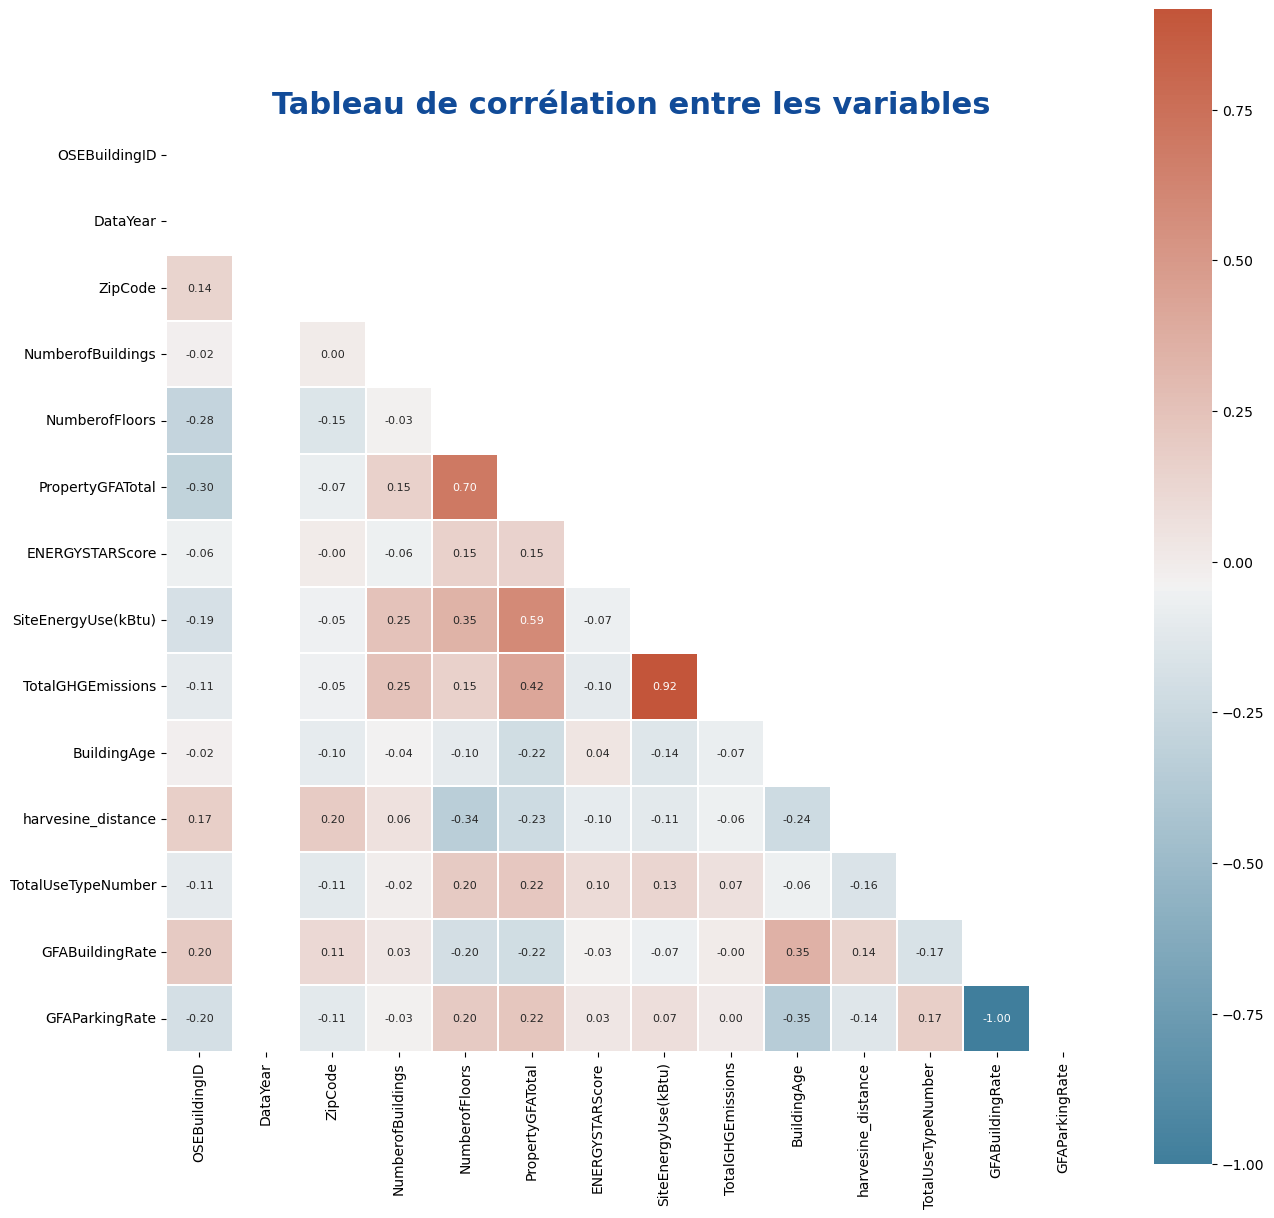

In [26]:
# Matrice des corrélations
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

#heatmap
fig = plt.figure(figsize=(15,15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, square=True, linewidths=0.01, mask = mask, annot=True, cmap=cmap, fmt='.2f', annot_kws={'size':8})
plt.title("Tableau de corrélation entre les variables", fontdict=police_titre)
plt.show()

Nous avons réduire les corrélations entre les variables en creant de nouvelles et en supprimant d'autres. Seules les variables cibles présentent des fortes corrélations, on créera alors un modèle de prédiction pour chacune des variables cibles. <br> Affichons les statistiques descriptives des variables afin de vérifier la cohérence dans les valeurs.

In [27]:
data.describe()

,OSEBuildingID,DataYear,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingAge,harvesine_distance,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate
count,1544.000000,1544.0,1531.000000,1544.000000,1544.000000,1.544000e+03,995.000000,1.544000e+03,1544.000000,1544.000000,1544.000000,1544.000000,1544.000000,1544.000000
mean,16449.573187,2016.0,98116.800131,1.141839,4.216321,1.154866e+05,63.631156,8.313037e+06,186.861975,54.361399,4.384404,1.952073,0.934722,0.065278
std,13792.671772,0.0,18.709420,1.182048,6.345617,1.979338e+05,28.813765,2.229810e+07,728.565724,32.847793,3.525143,1.239983,0.143945,0.143945
min,1.000000,2016.0,98006.000000,1.000000,0.000000,1.128500e+04,1.000000,5.713320e+04,0.000000,1.000000,0.032024,1.000000,0.100000,0.000000
25%,601.750000,2016.0,98104.000000,1.000000,1.000000,2.883575e+04,44.000000,1.251083e+06,20.655000,27.000000,1.346702,1.000000,1.000000,0.000000
50%,21179.500000,2016.0,98109.000000,1.000000,2.000000,4.812550e+04,71.000000,2.732167e+06,49.940000,50.500000,3.378807,2.000000,1.000000,0.000000
75%,24603.250000,2016.0,98125.000000,1.000000,4.000000,1.076615e+05,88.000000,7.294487e+06,147.227500,86.000000,6.603660,2.000000,1.000000,0.000000
max,50226.000000,2016.0,98199.000000,27.000000,76.000000,2.200000e+06,100.000000,4.483853e+08,16870.980000,116.000000,14.240955,13.000000,1.000000,0.900000


**_Tout semble correct, procédons à l'analyse de la distribution des variables cibles ("TotalGHGEmissions" et "SiteEnergyUse(kBtu)" : si leurs distributions sont différentes de la courbe de gauss, on procèdera à une normalisation._**

In [28]:
#importation des librairies pour le test de shapiro-wilk 
import scipy as scipy
from scipy import stats

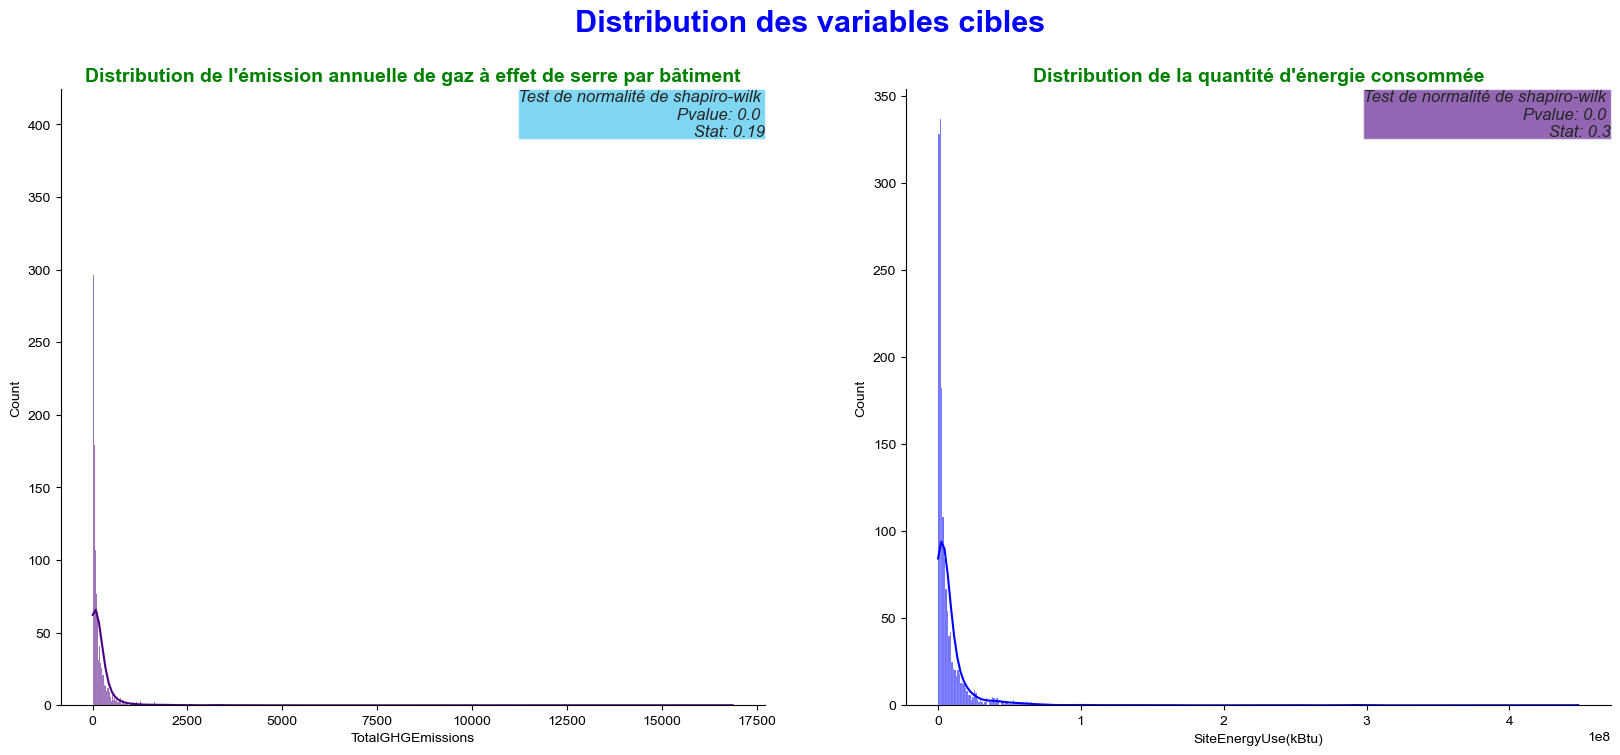

In [29]:
# Configuration de l'affichage
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))
left, width = 0, 1
bottom, height = 0, 1
right = left + width
top = bottom + height
sns.despine()
sns.set_style("darkgrid")


# Tracé de l'histogramme de l'émission de gaz
sns.histplot(data = data, x="TotalGHGEmissions",
             kde=True, color="indigo", ax = axes[0], alpha=0.6)

axes[0].set_title("Distribution de l'émission annuelle de gaz à effet de serre par bâtiment", fontsize=14, color= "green",
                 fontweight = "bold")

#Test de shapiro-wilk
shapiro_test = stats.shapiro(data["TotalGHGEmissions"])
axes[0].text(right, top, 
             'Test de normalité de shapiro-wilk \n Pvalue: {:.2} \n Stat: {:.2}'.format(shapiro_test.pvalue, 
                                                                                        shapiro_test.statistic),
            horizontalalignment='right',
            verticalalignment='top',
            style='italic', transform=axes[0].transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})

# Tracé de l'histogramme de la consommation d'énergie 
sns.histplot(data = data, x="SiteEnergyUse(kBtu)",
             kde=True, color="blue", ax = axes[1], alpha=0.6)

axes[1].set_title("Distribution de la quantité d'énergie consommée", fontsize=14, color= "green",
                 fontweight = "bold")

#Test de shapiro-wilk
shapiro_test = stats.shapiro(data["SiteEnergyUse(kBtu)"])
axes[1].text(right, top, 
             'Test de normalité de shapiro-wilk \n Pvalue: {:.2} \n Stat: {:.2}'.format(shapiro_test.pvalue, 
                                                                                        shapiro_test.statistic),
            horizontalalignment='right',
            verticalalignment='top',
            style='italic', transform=axes[1].transAxes, fontsize = 12,
            bbox={'facecolor':'indigo', 'alpha':0.6, 'pad':0})

plt.suptitle("Distribution des variables cibles", fontsize=22, color= "blue", fontweight = "bold")

plt.show()

Les p_values sont égales à 0. Les deux variables sont "anormalement distribuées".

**Afin d'optimiser nos modèles de prédiction, nous allons procéder à la transformation des variables cibles dans le but de les rapprocher au mieux d'une distribution normale**.
<br> Pour réaliser cette tâche, nous allons utiliser la FunctionTransformer, du module preprocessing de la librairie scikit-learn.

In [30]:
# Sauvegarde du dataframe
data_initial = data.copy()
data_initial.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingAge,harvesine_distance,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,98101.0,DOWNTOWN,1.0,12,88434,Hotel,60.0,7226362.5,249.98,89,0.800381,1,1.00,0.00
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,98101.0,DOWNTOWN,1.0,11,103566,Hotel,61.0,8387933.0,295.86,20,0.786421,3,0.85,0.15
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,98101.0,DOWNTOWN,1.0,41,956110,Hotel,43.0,72587024.0,2089.28,47,0.970191,1,0.79,0.21


Dans le jeu de données "data_initial", nous n'appliquerons pas de transformation sur les variables numériques ce qui nous permettra d'évaluer et comparer la performance de notre modélisation avec et sans transformation des variables.

**_Transformation des variables cibles_**

In [31]:
# Importation de la librairie 
from sklearn.preprocessing import FunctionTransformer

In [32]:
# Regroupement des variables cibles dans un array
variable_cible = data[["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]]

In [33]:
# Transformation des variables à l'aide de la fonction "FunctionTransformer"
logtransformer = FunctionTransformer(np.log1p, inverse_func = np.expm1, check_inverse = True) # log1p est utilisé pour les problèmes de division par 0
variable_cible_log = logtransformer.transform(variable_cible)

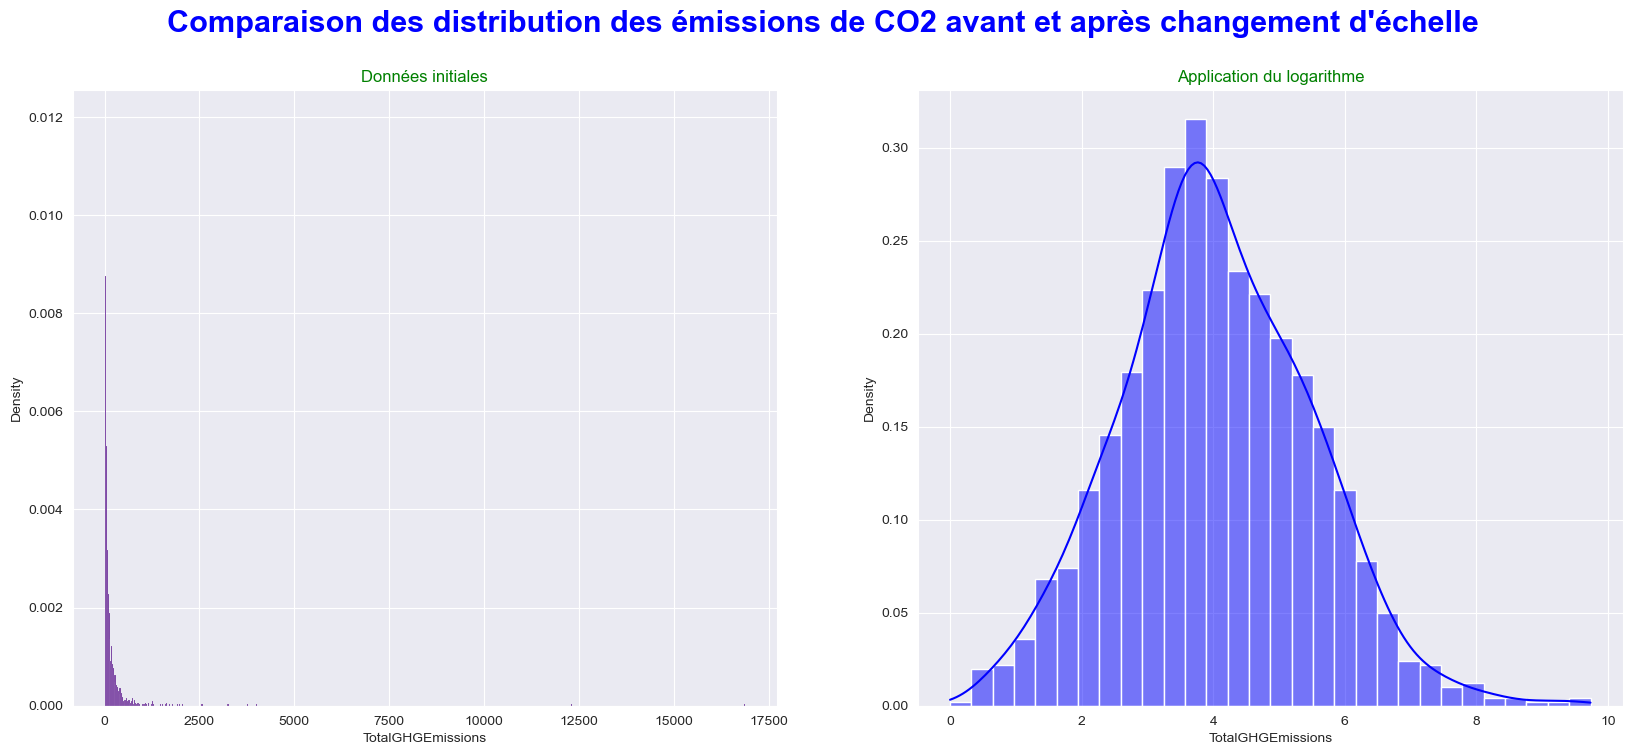

In [34]:
# Visualisation de l'impact de la transformation

# Configuration de la figure
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))

# Histogramme avant la transformation
sns.histplot(data = variable_cible, x='TotalGHGEmissions', stat="density", ax=axes[0], color = "indigo")
axes[0].set_title("Données initiales", color='green')

# Histogramme après transformation
sns.histplot(data=variable_cible_log, x='TotalGHGEmissions', stat="density", kde = True, ax=axes[1], color = "blue")
axes[1].set_title("Application du logarithme", color='green')


plt.suptitle("Comparaison des distribution des émissions de CO2 avant et après changement d'échelle", fontsize=22, color= "blue", fontweight = "bold")
plt.show()

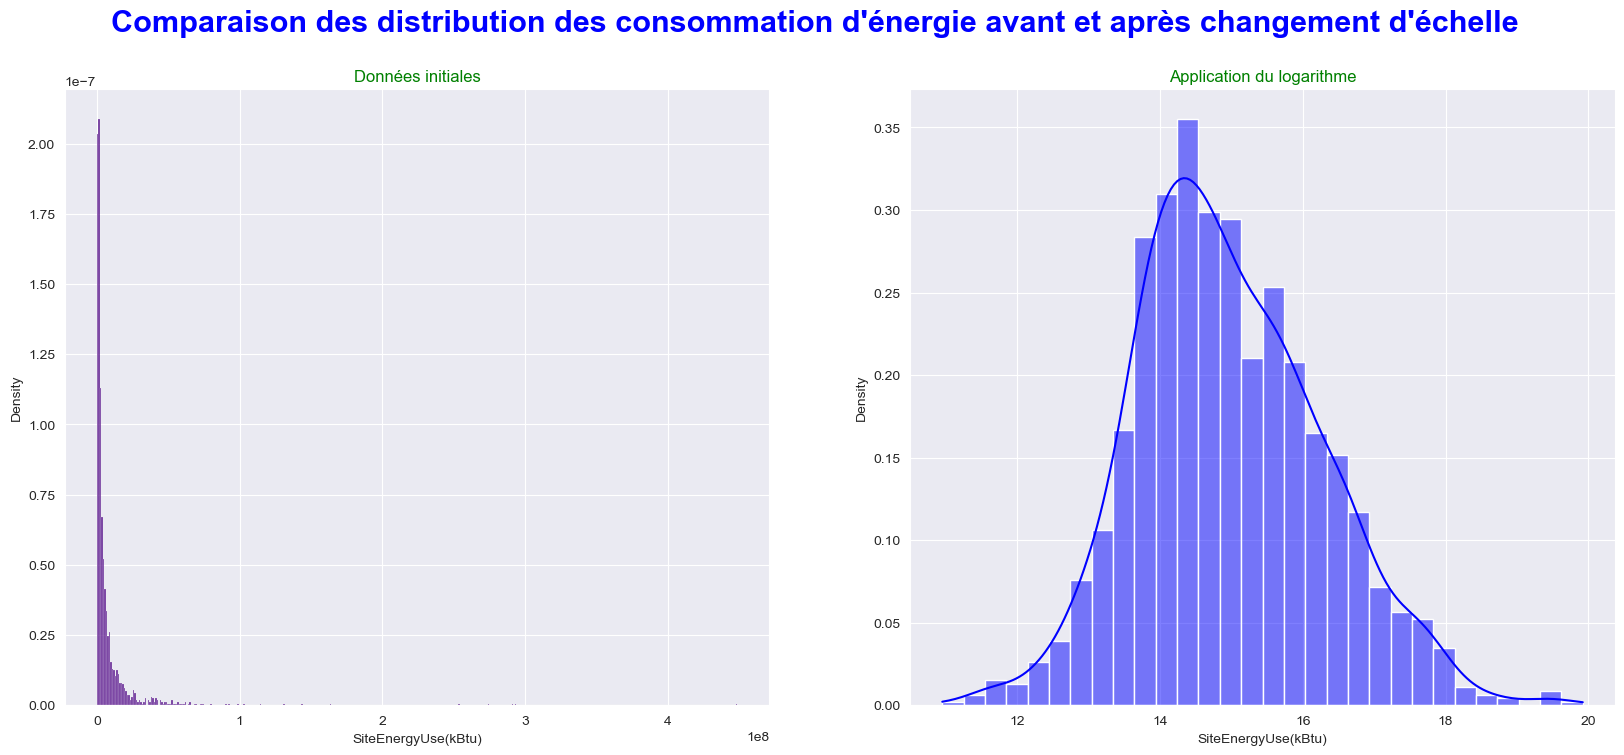

In [35]:
# Visualisation de l'impact de la transformation

# Configuration de la figure
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))

# Histogramme avant la transformation
sns.histplot(data = variable_cible, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[0], color = "indigo")
axes[0].set_title("Données initiales", color='green')

# Histogramme après transformation
sns.histplot(data=variable_cible_log, x='SiteEnergyUse(kBtu)', stat="density", kde = True, ax=axes[1], color = "blue")
axes[1].set_title("Application du logarithme", color='green')


plt.suptitle("Comparaison des distribution des consommation d'énergie avant et après changement d'échelle", fontsize=22, color= "blue", fontweight = "bold")
plt.show()

**_Les transformations logarithmiques ont permis de normaliser les distributions des variables_**

In [36]:
# Stockage des deux variables transformées dans un dataframe
data_log = pd.DataFrame(variable_cible_log, columns = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])

In [37]:
data_log

,SiteEnergyUse(kBtu),TotalGHGEmissions
0,15.793246,5.525373
1,15.942305,5.693261
2,18.100297,7.645053
3,15.731637,5.660979
4,16.466822,6.226556
...,...,...
1539,13.745177,3.060115
1540,13.764509,3.501646
1541,15.567472,5.414054
1542,13.486273,3.140265


Maintenant que les variables normalisées sont sauvegardées dans un nouveau dataframe, on peut les supprimer du jeu de données initial.

In [38]:
data.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis = 1, inplace = True)

In [39]:
data.sample(5)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,ENERGYSTARScore,BuildingAge,harvesine_distance,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate
925,22454,2016,NonResidential,Retail Store,Ballard Goodwill,6400 8th Avenue NW,98134.0,Ballard,1.0,1,22420,Retail Store,82.0,49,8.067535,1,1.00,0.00
971,23056,2016,NonResidential,Other,NATIONAL SIGN,1255 WESTLAKE AVE N,98109.0,MAGNOLIA / QUEEN ANNE,1.0,2,27144,Other,NaN,96,2.877658,1,1.00,0.00
1085,24118,2016,NonResidential,Warehouse,(ID24118) Industrial Way Building,650 S INDUSTRIAL WAY,98108.0,GREATER DUWAMISH,1.0,1,23296,Non-Refrigerated Warehouse,NaN,49,4.414197,2,1.00,0.00
808,21353,2016,NonResidential,Small- and Mid-Sized Office,FIRST BAPTIST CHURCH,1111 Harvard Ave.,98122.0,EAST,1.0,3,73549,Office,90.0,106,1.001167,2,1.00,0.00
429,652,2016,NonResidential,Large Office,West Seattle Corporate Center,4025 Delridge Way SW,98106.0,DELRIDGE,1.0,5,138106,Office,41.0,25,4.896645,2,0.88,0.12


## Preprocessing

A ce stade, les variables d'identification des bâtiments ne sont plus d'une importante utilité. Nous allons donc les séparer des autres variables.

In [40]:
# Sélection des variables d'identification
variables_identification = ['OSEBuildingID', 'PropertyName', 'Address', 'ZipCode']

# Sauvegarde des variables d'identifications dans un dataframe
data_identification = data[variables_identification]

# Suppression des variables d'identification du dataframe initial et du dataframe "normalisé"
data.drop(variables_identification, axis=1, inplace = True)
data_initial.drop(variables_identification, axis=1, inplace = True)

### Encodage des variables catégorielles

La majorité des estimateurs fonctionnant avec les données de type numériques, nos variables catégorielles vont être encodées à l'aide de la fonction get_dummies de la librairie pandas.
<br> 

_Commençons par extraire les variables catégorielles des dataframe._

In [41]:
variables_categorie = data.select_dtypes(exclude=['number']) 

#### Encodage

In [42]:
variables_categorie.nunique()

BuildingType               5
PrimaryPropertyType       20
Neighborhood              19
LargestPropertyUseType    56
dtype: int64

In [43]:
data = pd.get_dummies(data = data, columns = ["BuildingType", "PrimaryPropertyType", "Neighborhood", "LargestPropertyUseType"], 
                                              drop_first=True)
data.head()

,DataYear,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,BuildingAge,harvesine_distance,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,...,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Unknown,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Wholesale Club/Supercenter,LargestPropertyUseType_Worship Facility
0,2016,1.0,12,88434,60.0,89,0.800381,1,1.00,0.00,...,0,0,0,0,0,0,0,0,0,0
1,2016,1.0,11,103566,61.0,20,0.786421,3,0.85,0.15,...,0,0,0,0,0,0,0,0,0,0
2,2016,1.0,41,956110,43.0,47,0.970191,1,0.79,0.21,...,0,0,0,0,0,0,0,0,0,0
3,2016,1.0,10,61320,56.0,90,0.943946,1,1.00,0.00,...,0,0,0,0,0,0,0,0,0,0
4,2016,1.0,18,175580,75.0,36,1.048559,3,0.65,0.35,...,0,0,0,0,0,0,0,0,0,0


In [44]:
data_initial = pd.get_dummies(data = data_initial, columns = ["BuildingType", "PrimaryPropertyType", "Neighborhood", "LargestPropertyUseType"], 
                                              drop_first=True)
data_initial.head()

,DataYear,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingAge,harvesine_distance,TotalUseTypeNumber,...,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Self-Storage Facility,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Social/Meeting Hall,LargestPropertyUseType_Strip Mall,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Unknown,LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient,LargestPropertyUseType_Wholesale Club/Supercenter,LargestPropertyUseType_Worship Facility
0,2016,1.0,12,88434,60.0,7226362.5,249.98,89,0.800381,1,...,0,0,0,0,0,0,0,0,0,0
1,2016,1.0,11,103566,61.0,8387933.0,295.86,20,0.786421,3,...,0,0,0,0,0,0,0,0,0,0
2,2016,1.0,41,956110,43.0,72587024.0,2089.28,47,0.970191,1,...,0,0,0,0,0,0,0,0,0,0
3,2016,1.0,10,61320,56.0,6794584.0,286.43,90,0.943946,1,...,0,0,0,0,0,0,0,0,0,0
4,2016,1.0,18,175580,75.0,14172606.0,505.01,36,1.048559,3,...,0,0,0,0,0,0,0,0,0,0


In [45]:
data_transformer = pd.concat([data_log, data], axis = 1)
data_non_transformer = data_initial

In [46]:
data_transformer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1544 entries, 0 to 1543
Columns: 108 entries, SiteEnergyUse(kBtu) to LargestPropertyUseType_Worship Facility
dtypes: float64(7), int64(5), uint8(96)
memory usage: 289.6 KB


In [47]:
data_non_transformer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1544 entries, 0 to 1543
Columns: 108 entries, DataYear to LargestPropertyUseType_Worship Facility
dtypes: float64(7), int64(5), uint8(96)
memory usage: 289.6 KB


Maintenant que les données sont transformées, encodées et standardisées, on peut exporter pour la modélisation

In [48]:
data_transformer.to_csv("building_data_transformer_modelisation.csv")
data_non_transformer.to_csv("building_data_non_transformer_modelisation.csv")